# ChBE 6745 Course Project
Date : 04-17-2020

**Group 8**

*Group members: Aaron Liu, Brian Khau, Max Bukhovko, Nicole (Yuge) Hu, Rahul Venkatesh*

## Background
### Context
PET and many polyesters are susceptible to thermo-oxidative decomposition, especially when exposed to high temperatures. As this degradation causes a significant drop in mechanical properties, additives are typically blended into the polymer to enhance thermal stability. Thus, a contemporary problem is the **discovery of small-molecule additives** that can adequately improve the mechanical property persistence of polymer fibers after thermal exposure.

To quantify "stability", we will be using a metric known as **tenacity persistence** as our response variable $y$. This quantity is defined as:

\begin{align*}
  y = \frac{\text{tenacity after treatment}}{\text{tenacity before treatment}} (100\%)
\end{align*}

Tenacity is a measure of a fiber's ultimate breaking strength; the higher the tenacity, the more resistant the fiber is against breaking. In this case study, the samples were held in a water vessel and placed in a heater at 120$^\circ$C for 3 days. 

### Objective
The main objective of this project is to use a database of small-molecule additives and their calculated molecular descriptors to predict the tenacity persistence for polyethylene terephthlate (PET) fibers after heat exposure. This construct is also known as a quantitative structure-activity relationship (QSAR) model. **Because we are attempting to quantify a continuous variable, we will be using a QSAR regression model.**



### Dataset Details
* The data outlined in the Excel file `PETadditives_database_and_descriptors.csv` has previously been mined from patent US 3,491,057. This patent describes multiple nitrogen-containing additives added to PET fibers to improve their thermo-oxidative stability.  
* The response variable $y$ refers to the experimentally measured tenacity persistence for PET fibers augmented with a given additive. Note that $y$ has been measured in several different ways, such as in dry conditions after 1 hour, or wet conditions after 15 hours. 
* The features ($x_0$, $x_1$, $x_2$...)are molecular descriptors derived from the structure of the additive. These include descriptors such as molecular weight and branching, and were previously calculated using alvaDesc 1.0.12. Our dataset consists of 42 observations with 1862 molecular desciptors. For a complete list on the molecular descriptors, refer to this link: https://www.alvascience.com/alvadesc-descriptors/

## Baseline Model 

### Summary
In our baseline model, we performed a simple principle component regression (PCR), where we applied the following steps.
1. Scale the entire dataset. (Standard scaling)
2. Split the dataset into training and validation datasets using `train_test_split` with a hold out percentage of 20%. 
3. Naive implementation of PCA on all feature space to identify high variance principal components. 
4. Perform dimensionality reduction by using an arbitrary heuristic of retaining principal components which total to 90% of cumulative variance. 
5. Develop a linear regression model based on this subset of principal components. 
6. Assess the fitting of the given model on validation data.

### Major fallacies with our baseline model
Notably, our baseline model exhibits 3 major fallacies:
1. Scaling the entire dataset. This contaminates the validation data set because the mean and variance used to calculate the model should only be based on the training dataset.
2. Naive implementation of PCA results in loss in performance compared to the SciKit-Learn implementation.
3. Use of a threshold heuristic. This fixes the number of principal components used and provides no control to optimize the model.

## Improved Methodology
We have improved our modeling pipeline to account for these fallacies.
1. **Improved speed, efficiency, and clarity.** We use the `Pipeline()` class to wrap together all our transforms and estimators, including scaling. In addition, we will use built-in functions whenever possible (such as `PCA()`).

2. **Cross-validation/resampling accuracy estimates.**  We implement `LeaveOneOut()` or `KFold()` implicitly through `GridSearchCV()` to aid in hyperparameter tuning. This enables us to select appropriate hyperparameters, such as the number of principal components or regularization strength.

3. **More generalized regression models.** `LinearRegression()` works best when the underlying model exhibits linear correlations. Because this assumption may not hold (as with use of discrete variables or nonlinear trends), we have also looked models that perform feature selection (`LASSO()`) and dimensionality reduction(`PCA()`, `PLS()`). We will try a nonlinear PCA like kernel PCA in a future iteration of this model.

## Report accomplishments
Refer to the below figure for a visual explanation of our pipeline. In this report, we have compared the performance of the following pipelines using `LeaveOneOut()` cross-validation from `GridSearchCV()`.

### Pipeline Description
Model from previous report:
* Streamlined Baseline Model: Principal Component Regression (PCR).
    * pipeline = `StandardScaler()`, `PCA()`, `LinearRegression()`

Linear models:
* Naive model: Ordinary Least Squares (OLS).
    * pipeline = `StandardScaler()`, `LinearRegression()`
* Improved Model 1: L1-regularized least-squares (LASSO).
    * pipeline = `StandardScaler()`, `Lasso()`
* Improved Model 2: Partial-least squares regression (PLSR).
    * pipeline= `StandardScaler()`, `PLSRegression()`

Advanced models:
* Improved Model 3: Neural networks.
    * This is accomplished using code other than a pipeline; refer to the end of the document for more details on results and implementation.

### Summary of (Linear) Model Results

Note that while the summary for the linear models are here, the artificial neural network was tested on numerous different test-validation splits at the end of the document.

Using `np.random.seed(0)`:

|        | Hyperparameter | Training R2 | Validation R2 | Training RMSE | Validation RMSE |
|--------|----------------|-------------|---------------|---------------|-----------------|
| OLS    |                | 1.0000      | -4.4251       | 0.0000        | 3.8539          |
| PCR    | 19 components  | 0.8350      | -2.0211       | 1.1167        | 2.8759          |
| LASSO  | alpha=0.316    | 0.8554      | -2.2197       | 1.0455        | 2.9690          |
| PLSR   | 4 components   | 1.0000      | -4.4249       | 0.0112        | 3.8539          |

Using `np.random.seed(10)`:

|       | Hyperparameter| Training R2 | Validation R2 | Training RMSE | Validation RMSE |
|-------|---------------|-------------|---------------|---------------|-----------------|
| OLS   |               | 1.0000      | -1.0536       | 0.0000        | 2.8496          |
| PCR   | 10 components | 0.5320      | -0.1913       | 1.8608        | 2.1704          |
| LASSO | alpha = 0.316 | 0.8235      | -4.9698       | 1.1428        | 4.8586          |
| PLSR  | 4 components  | 0.7931      | -1.0244       | 1.2371        | 2.8293          |

Using `np.random.seed(40)` (as a "lucky" seed):

|       | Hyperparameter | Training R2 | Validation R2 | Training RMSE | Validation RMSE |
|-------|----------------|-------------|---------------|---------------|-----------------|
| OLS   |                | 1.0000      | 0.1603        | 0.0000        | 2.3059          | 
| PCR   | 10 components  | 0.5096      | 0.2350        | 1.8195        | 2.2009          |
| LASSO | alpha=0.233    | 0.8673      | 0.0678        | 0.9465        | 2.4295          |
| PLSR  | 4 components   | 0.7389      | 0.2827        | 1.3276        | 2.1311          |

## Import Data and Read into pandas

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns

df = pd.read_csv('PETadditives_database_and_descriptors.csv',index_col="No.")
df.head(3) # First 5 columns

,NAME,Addition Method,Amount Added,dry 1 hr,dry 2 hr,dry 3 hr,wet 3 day,wet 5 day,wet 15 day,MW,...,BLTA96,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02
No.,,,,,,,,,,,,,,,,,,,,,
1,CC1=CC=CC=C1N=C=NC2=CC=CC=C2C,A,0.25,68.5,59.0,50.7,18.8,0.0,0.0,222.31,...,-5.190376,1.0,1.000000,1.000000,0.6,0.5,1.0,0.871429,0.833333,1.0
2,O=C(N1)C2=CC=CC(CC3=CC=CC=C3)=C2C1=O,A,0.25,78.1,70.0,63.5,69.6,30.7,6.4,237.27,...,-4.354596,1.0,1.000000,1.000000,0.6,0.0,1.0,0.800000,0.833333,1.0
3,O=C(N1)C2=CC=CC(C(C)=O)=C2C1=O,A,0.25,74.3,67.6,60.1,55.1,22.4,0.0,189.18,...,-2.608074,1.0,0.833333,0.833333,0.4,0.0,1.0,0.723810,0.666667,1.0


## Filter Data

Since our dataset above contains various processing parameters, such as additive method and the amount of additive added, we additionally filtered the observations to correspond to additive method A and 0.25 as the amount added. Also note that we have multiple outputs, corresponding to tenacities measured at different conditions. **We will be using the first output, dry 1 hour.**

In [2]:
# filter and extract dry 0 hr values as y
df_filtered = df[(df['Amount Added'] == 0.25)&(df['Addition Method'] == 'A')]
df_Y = df_filtered.iloc[:,3:9]
df_Y.head(2)

,dry 1 hr,dry 2 hr,dry 3 hr,wet 3 day,wet 5 day,wet 15 day
No.,,,,,,
1,68.5,59.0,50.7,18.8,0.0,0.0
2,78.1,70.0,63.5,69.6,30.7,6.4


In [3]:
# Define X dataframe

df_X = df_filtered.iloc[:,9:]
# mask out columns where all the rows are the same value
nunique = df_X.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_X.drop(cols_to_drop, axis=1)
df_X.head(2)

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,BLTA96,DLS_01,DLS_02,DLS_03,DLS_04,DLS_05,DLS_06,DLS_cons,LLS_01,LLS_02
No.,,,,,,,,,,,,,,,,,,,,,
1,222.31,7.171290,20.2036,30.5052,21.5798,34.4878,0.651729,0.984039,0.696123,1.11251,...,-5.190376,1.0,1.0,1.0,0.6,0.5,1.0,0.871429,0.833333,1.0
2,237.27,8.181724,20.0850,29.1744,20.7217,31.9931,0.692586,1.006014,0.714541,1.10321,...,-4.354596,1.0,1.0,1.0,0.6,0.0,1.0,0.800000,0.833333,1.0


## Model Helper Functions

To improve readability within this notebook, we have constructed a small set of helper functions that encapsulate visualization or pipeline tasks later on:

The `parity_plotter` code block takes in a fitted `GridSearch` object along with the testing and validation data.
* Plots the corresponding parity plot using the object's best estimator.
* Prints out the R2 and RMSE scores for the training and validation sets.

In [4]:
from sklearn.metrics import mean_squared_error

def parity_plotter(grid_search_obj, X_train, X_valid, y_train, y_valid):
    # input: gridsearch object, training and validation datasets
    # output: None
    # prints out parity plots and scores
    
    # Compute and output scores
    print("Best parameters: {}".format(grid_search_obj.best_params_))
    
    yhat_train = grid_search_obj.best_estimator_.predict(X_train)
    train_score = grid_search_obj.best_estimator_.score(X_train, y_train)
    print("Training R2 score: {}".format(train_score))
    rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
    print("Training RMSE: {}".format(rmse_train))

    yhat_valid = grid_search_obj.best_estimator_.predict(X_valid)
    valid_score = grid_search_obj.best_estimator_.score(X_valid, y_valid)
    print("Validation R2 score: {}".format(valid_score))
    rmse_train = np.sqrt(mean_squared_error(y_valid, yhat_valid))
    print("Validation RMSE: {}".format(rmse_train))

    # Superimpose testing and training points
    fig, ax = plt.subplots()
    ax.scatter(y_train, yhat_train, label='training')
    ax.scatter(y_valid, yhat_valid, label='validation')
    ax.plot(y_train, y_train, 'k-')
          
    ax.set_xlabel("Actual y")
    ax.set_ylabel("Predicted y")
    ax.legend()
          
    return

The `gridsearch_pipeline_fit` code block takes in `Pipeline` object for the model, a parameter grid, and the associated training and validation data. 
* Fits and returns a `GridSearch` object. 
* Prints out the best hyperparameters for the associated pipeline. 

In [5]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer, mean_squared_error

def gridsearch_pipeline_fit(pipe, param_grid, X_train, X_valid, y_train, y_valid):
    # input: pipeline object, parameter grid (as dict)
    # uses leave one out cross-validation iterator with score as max_error
    # output: grid_search_obj
    
    cv = LeaveOneOut()

    def rmse(y_true, y_pred):
        rms = np.sqrt(mean_squared_error(y_true, y_pred))
        return rms
    rmse_score = make_scorer(rmse)

    # search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='max_error',n_jobs=-1,cv=cv,return_train_score=True)
    search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=rmse_score, n_jobs=-1,cv=cv,return_train_score=True)
    search.fit(X_train, y_train) 
    
    print("Best parameter (CV test score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    
    return search

The `one_param_plotter` function takes in a fitted `GridSearch` object, the hyperparameter to plot against, and the associated testing data.
* Plots the mean training and testing errors associated with cross-validation.

In [6]:
def one_param_plotter(grid_search_obj, hyperparameter, X_train, X_test,is_log=False):
    # input: grid_search_object, hyperparameter as string
    # plots training/testing score as a function of hyperparameter (with errors) 
    # output:None
    
    if len(grid_search_obj.param_grid) != 1:
        print("cannot plot more than one hyperparameter")
        return
    
    if hyperparameter not in grid_search_obj.param_grid.keys():
        print("key does not exist in param_grid")
        return
    
    N_train = search.cv.get_n_splits(X_train)
    N_test = search.cv.get_n_splits(X_test)
    
    train_scores = grid_search_obj.cv_results_['mean_train_score']
    train_scores_stdev = grid_search_obj.cv_results_['std_train_score']/np.sqrt(N_train)

    test_scores = grid_search_obj.cv_results_['mean_test_score']
    test_scores_stdev = grid_search_obj.cv_results_['std_test_score']/np.sqrt(N_test)

    # plot error lines showing +/- std. deviation of the scores
    train_std_error = train_scores_stdev
    test_std_error = test_scores_stdev
    
    param_range = grid_search_obj.param_grid[hyperparameter]
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    
    if is_log: # linear plot
        # plot training scores   
        ax[0].semilogx(param_range, train_scores + train_std_error, 'b--')
        ax[0].semilogx(param_range, train_scores - train_std_error, 'b--')
        ax[0].semilogx(param_range, train_scores, 'ko-')
        # plot testing scores
        ax[1].semilogx(param_range, test_scores + test_std_error, 'b--')
        ax[1].semilogx(param_range, test_scores - test_std_error, 'b--')
        ax[1].semilogx(param_range, test_scores, 'ko-')  
        
    else:   # linear plot
        # plot training scores   
        ax[0].plot(param_range, train_scores + train_std_error, 'b--')
        ax[0].plot(param_range, train_scores - train_std_error, 'b--')
        ax[0].plot(param_range, train_scores, 'ko-')
        # plot testing scores
        ax[1].plot(param_range, test_scores + test_std_error, 'b--')
        ax[1].plot(param_range, test_scores - test_std_error, 'b--')
        ax[1].plot(param_range, test_scores, 'ko-')  
        
    ax[0].fill_between(param_range, 
                       train_scores + train_std_error, train_scores - train_std_error, alpha=0.2)
    ax[0].set_ylabel('Train RMSE +/- std error')
    ax[0].set_xlabel(hyperparameter)
    ax[0].axhline(np.max(train_scores), linestyle='--', color='.5')
    ax[0].set_title('Train RMSE vs {}'.format(hyperparameter))

    ax[1].fill_between(param_range, 
                       test_scores + test_std_error, test_scores - test_std_error, alpha=0.2)
    ax[1].set_ylabel('Test RMSE +/- std error')
    ax[1].set_xlabel(hyperparameter)
    ax[1].axhline(np.max(test_scores), linestyle='--', color='.5')
    ax[1].set_title('Test RMSE vs {}'.format(hyperparameter))

    return fig, ax

## Split Dataset for Testing and Validation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Streamlined Baseline Model (PCA + Linear Regression)

Here, we implement our baseline model as before, but we optimize the number of principal components to use with the `Pipeline` class in combination with `GridSearchCV`. We apply the baseline model steps (scaled principal component regression) onto the Dataframes we created earlier.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# Split the dataframes with 20% hold out
np.random.seed(40) # May change later

df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_Y, test_size=0.20)
df_X_train, df_y_train = shuffle(df_X_train, df_y_train)


# Create pipeline
scaler = StandardScaler()
pca = PCA()
lr = LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('PCA', pca), ('linear_regression', lr)] )
param_grid = {'PCA__n_components': 3+np.arange(17)}

search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

Best parameter (CV test score=2.348):
{'PCA__n_components': 17}


(<Figure size 1080x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a3c794d10>,
       dtype=object))

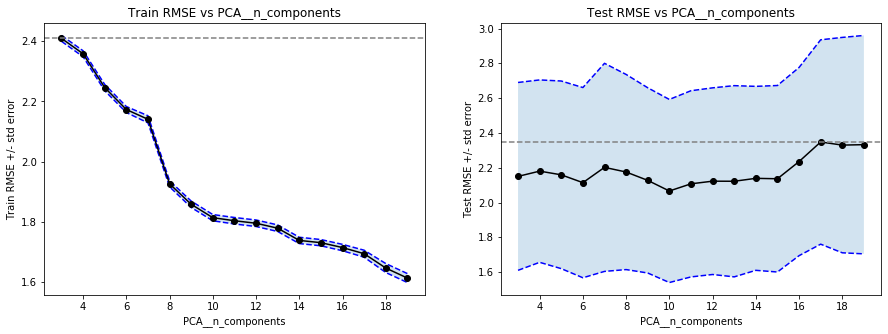

In [9]:
one_param_plotter(search, 'PCA__n_components', df_X_train, df_X_test)

Best parameters: {'PCA__n_components': 17}
Training R2 score: 0.5602009822432858
Training RMSE: 1.7230232008754933
Validation R2 score: 0.2525321533486937
Validation RMSE: 2.1755551542033875


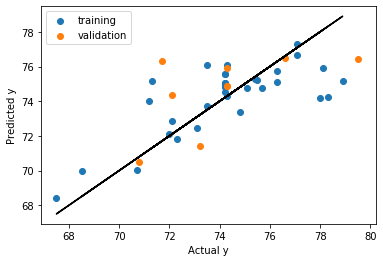

In [10]:
parity_plotter(search, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

In [11]:

def plot_sensitivity(r2_train_list, r2_valid_list, rmse_train_list, rmse_valid_list, figName=None):
    fig, ax = plt.subplots(1, 2, figsize=[10,5])

    ax[0].scatter(range(1, len(r2_train_list)+1), r2_valid_list, marker='.', label='test')
    ax[0].scatter(range(1, len(r2_train_list)+1), r2_train_list, marker='+', color='r',label='train')
    ax[0].set_xlabel('Validation #')
    ax[0].set_ylabel('r_2')
    ax[0].legend()

    print('r2 for training set = {:.4f} +- {:.4f}'.format(np.mean(r2_train_list), np.std(r2_train_list)))
    print('r2 for validation set = {:.4f} +- {:.4f}'.format(np.mean(r2_valid_list), np.std(r2_valid_list)))

    # rmse plot

    ax[1].scatter(range(1, len(r2_train_list)+1), rmse_valid_list, marker='.', label='test')
    ax[1].scatter(range(1, len(r2_train_list)+1), rmse_train_list, marker='+', color='r',label='train')
    ax[1].set_xlabel('Validation #')
    ax[1].set_ylabel('RMSE')
    ax[1].legend()

    print('RMSE for training set = {:.4f} +- {:.4f}'.format(np.mean(rmse_train_list), np.std(rmse_train_list)))
    print('RMSE for validation set = {:.4f} +- {:.4f}'.format(np.mean(rmse_valid_list), np.std(rmse_valid_list)))

    if figName is not None:
        fig.savefig(figName+'.png', dpi=300, bbox_inches='tight')

    return



Best parameter (CV test score=2.475):
{'PCA__n_components': 16}
Best parameter (CV test score=2.328):
{'PCA__n_components': 16}
Best parameter (CV test score=2.282):
{'PCA__n_components': 17}
Best parameter (CV test score=2.121):
{'PCA__n_components': 5}
Best parameter (CV test score=2.330):
{'PCA__n_components': 17}
Best parameter (CV test score=2.236):
{'PCA__n_components': 16}
Best parameter (CV test score=2.236):
{'PCA__n_components': 16}
Best parameter (CV test score=2.213):
{'PCA__n_components': 15}
Best parameter (CV test score=2.286):
{'PCA__n_components': 3}
Best parameter (CV test score=2.479):
{'PCA__n_components': 18}
Best parameter (CV test score=2.512):
{'PCA__n_components': 19}
Best parameter (CV test score=2.428):
{'PCA__n_components': 18}
Best parameter (CV test score=2.004):
{'PCA__n_components': 3}
Best parameter (CV test score=2.441):
{'PCA__n_components': 16}
Best parameter (CV test score=2.113):
{'PCA__n_components': 4}
Best parameter (CV test score=2.721):
{'PCA_

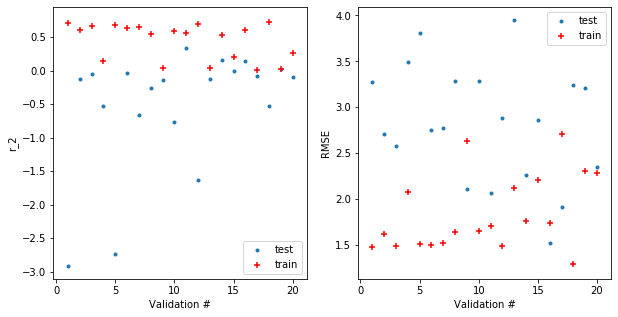

In [12]:
# Iterations to get the performance of validation

np.random.seed(0) # May change later

num_iter = 20

list_RMSE_training = []
list_RMSE_validation = []
list_r2_training = []
list_r2_validation = []
list_params = []
hyperparameter = 'PCA__n_components'


for i in range(num_iter):
    df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_Y, test_size=0.20)
    df_X_train, df_y_train = shuffle(df_X_train, df_y_train)
    search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])
    yhat_train = search.best_estimator_.predict(df_X_train)
    train_score = search.best_estimator_.score(df_X_train, df_y_train.iloc[:,0])
    rmse_train = np.sqrt(mean_squared_error(df_y_train.iloc[:,0], yhat_train))
    yhat_valid = search.best_estimator_.predict(df_X_test)
    valid_score = search.best_estimator_.score(df_X_test, df_y_test.iloc[:,0])
    rmse_valid = np.sqrt(mean_squared_error(df_y_test.iloc[:,0], yhat_valid))

    list_RMSE_training.append(rmse_train)
    list_RMSE_validation.append(rmse_valid)
    list_r2_training.append(train_score)
    list_r2_validation.append(valid_score)
    list_params.append(search.best_params_[hyperparameter])
    # list_RMSE_validation.append(search.best_estimator_.test_scores)

plot_sensitivity(list_r2_training, list_r2_validation, list_RMSE_training, list_RMSE_validation)

In [13]:
# print validation score with hyperparameters

print(list_params)

fmt = '%-5s%-20s%10s'

print(fmt % ('', 'r2_valid', 'num_PCA'))
for i, (a, b) in enumerate(zip(list_r2_validation, list_params)):
    print(fmt % (i, a, b))

[16, 16, 17, 5, 17, 16, 16, 15, 3, 18, 19, 18, 3, 16, 4, 19, 3, 19, 3, 6]
     r2_valid               num_PCA
0    -2.9155413281843923         16
1    -0.11667552832927575        16
2    -0.04727392616900006        17
3    -0.5232264826754967          5
4    -2.7356724221537263         17
5    -0.03277442180874646        16
6    -0.6573764343133839         16
7    -0.2603741046175989         15
8    -0.14463016196361922         3
9    -0.7656004872063644         18
10   0.34710430147816174         19
11   -1.6318337994231207         18
12   -0.12914611479256188         3
13   0.15662756565571082         16
14   -0.000791645832963539         4
15   0.1482735311545308          19
16   -0.0782799207285978          3
17   -0.5195304660778259         19
18   0.03290031631609325          3
19   -0.08838460711601948         6


##  Naive Model (Linear Regression)

LR Training score: 1.0
Training RMSE: 1.3321779115373886e-14
LR Test score: -2.1691692248725376
Test RMSE: 4.011525528284099


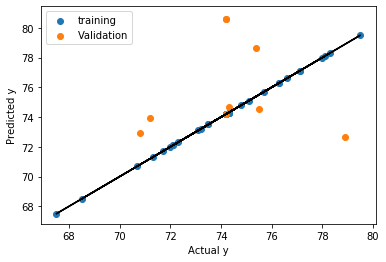

In [14]:
# Create pipeline
scaler = StandardScaler()
lr = LinearRegression()
pipe = Pipeline(steps=[('scaler', scaler), ('lr', lr)])

# Fit 
pipe.fit(df_X_train, df_y_train.iloc[:,0]) # Fit only the first column (dry 0 h)

yhat_train = pipe.predict(df_X_train)
print("LR Training score: {}".format(pipe.score(df_X_train, df_y_train.iloc[:,0])))
rmse_train = np.sqrt(mean_squared_error(df_y_train.iloc[:,0], yhat_train))
print("Training RMSE: {}".format(rmse_train))
yhat_test = pipe.predict(df_X_test)
print("LR Test score: {}".format(pipe.score(df_X_test, df_y_test.iloc[:,0])))
rmse_test = np.sqrt(mean_squared_error(df_y_test.iloc[:,0], yhat_test))
print("Test RMSE: {}".format(rmse_test))

# Superimpose testing and training points
fig, ax = plt.subplots()
ax.scatter(df_y_train.iloc[:,0], yhat_train, label='training')
ax.scatter(df_y_test.iloc[:,0], yhat_test, label='Validation')
ax.plot(df_y_train.iloc[:,0], df_y_train.iloc[:,0], 'k-')
ax.set_xlabel("Actual y")
ax.set_ylabel("Predicted y")
ax.legend()

r2 for training set = 1.0000 +- 0.0000
r2 for validation set = -0.8255 +- 1.1575
RMSE for training set = 0.0000 +- 0.0000
RMSE for validation set = 3.1929 +- 0.7589


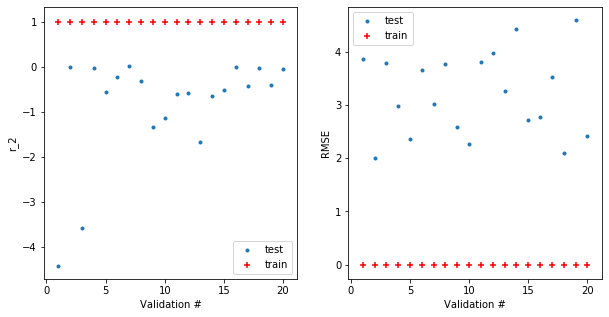

In [15]:
np.random.seed(0) # May change later

num_iter = 20

list_RMSE_training = []
list_RMSE_validation = []
list_r2_training = []
list_r2_validation = []
# list_params = []
# hyperparameter = 'PCA__n_components'


for i in range(num_iter):
    df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_Y, test_size=0.20)
    df_X_train, df_y_train = shuffle(df_X_train, df_y_train)
    pipe.fit(df_X_train, df_y_train.iloc[:,0])
    yhat_train = pipe.predict(df_X_train)
    train_score = pipe.score(df_X_train, df_y_train.iloc[:,0])
    rmse_train = np.sqrt(mean_squared_error(df_y_train.iloc[:,0], yhat_train))
    yhat_valid = pipe.predict(df_X_test)
    valid_score = pipe.score(df_X_test, df_y_test.iloc[:,0])
    rmse_valid = np.sqrt(mean_squared_error(df_y_test.iloc[:,0], yhat_valid))

    list_RMSE_training.append(rmse_train)
    list_RMSE_validation.append(rmse_valid)
    list_r2_training.append(train_score)
    list_r2_validation.append(valid_score)
    list_params.append(search.best_params_[hyperparameter])
    # list_RMSE_validation.append(pipe.test_scores)

plot_sensitivity(list_r2_training, list_r2_validation, list_RMSE_training, list_RMSE_validation)

In [16]:

fmt = '%-5s%-25s%10s'

print(fmt % ('', 'r2_valid', 'r2_training'))
for i, (a, b) in enumerate(zip(list_r2_validation, list_r2_training)):
    print(fmt % (i, a, b))

r2_valid                 r2_training
0    -4.425117407173589              1.0
1    -0.01439998265391984            1.0
2    -3.5824386523573652             1.0
3    -0.032669596701094594           1.0
4    -0.5683609346172933             1.0
5    -0.22231901539683574            1.0
6    0.028295242822912847            1.0
7    -0.32209718690599587            1.0
8    -1.3305535003095708             1.0
9    -1.1350989525104644             1.0
10   -0.6003202231713447             1.0
11   -0.5773060262781537             1.0
12   -1.6575393492845385             1.0
13   -0.6414191467705992             1.0
14   -0.5221470496341543             1.0
15   -0.006923397208517645           1.0
16   -0.4148030676378703             1.0
17   -0.01567126961481824            1.0
18   -0.4112061383528067             1.0
19   -0.05710888154254201            1.0


## Improved Model 1 (LASSO Regression)

In [9]:
from sklearn.linear_model import Lasso

# Create pipeline
scaler = StandardScaler()
lasso = Lasso(max_iter = 100000, tol = 0.0001) 
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
param_grid = {'lasso__alpha': np.logspace(-3,-0.5,20)}

search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

Best parameter (CV test score=3.574):
{'lasso__alpha': 0.006158482110660267}


(<Figure size 1080x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a2b1a6dd0>,
       dtype=object))

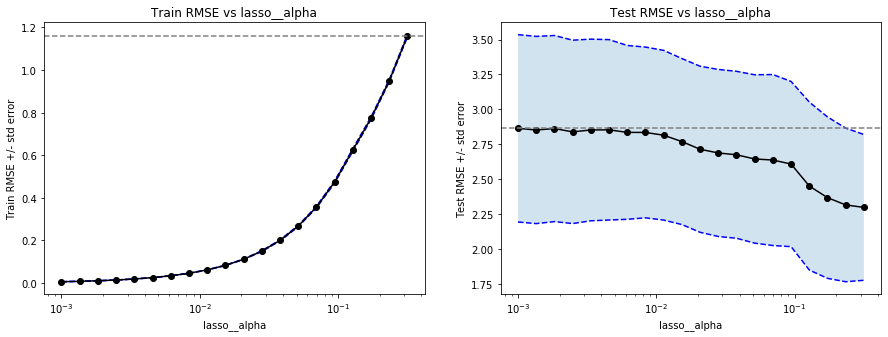

In [18]:
one_param_plotter(search, 'lasso__alpha', df_X_train, df_X_test, is_log=True)

Best parameters: {'lasso__alpha': 0.001}
Training R2 score: 0.9999954235510686
Training RMSE: 0.005628106466614268
Validation R2 score: -0.20962326445898105
Validation RMSE: 2.5858034079476884


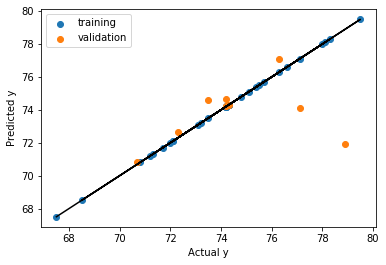

In [19]:
parity_plotter(search, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

Best parameter (CV test score=2.530):
{'lasso__alpha': 0.001}
Best parameter (CV test score=2.933):
{'lasso__alpha': 0.007742636826811269}
Best parameter (CV test score=2.760):
{'lasso__alpha': 0.007742636826811269}
Best parameter (CV test score=2.356):
{'lasso__alpha': 0.0027825594022071257}
Best parameter (CV test score=3.069):
{'lasso__alpha': 0.0027825594022071257}
Best parameter (CV test score=1.796):
{'lasso__alpha': 1.2915496650148828}
Best parameter (CV test score=2.139):
{'lasso__alpha': 0.007742636826811269}
Best parameter (CV test score=2.512):
{'lasso__alpha': 0.021544346900318832}
Best parameter (CV test score=1.893):
{'lasso__alpha': 0.46415888336127775}
Best parameter (CV test score=1.953):
{'lasso__alpha': 0.46415888336127775}
Best parameter (CV test score=2.640):
{'lasso__alpha': 0.001}
Best parameter (CV test score=2.884):
{'lasso__alpha': 0.001}
Best parameter (CV test score=2.240):
{'lasso__alpha': 0.1668100537200059}
Best parameter (CV test score=2.064):
{'lasso__a

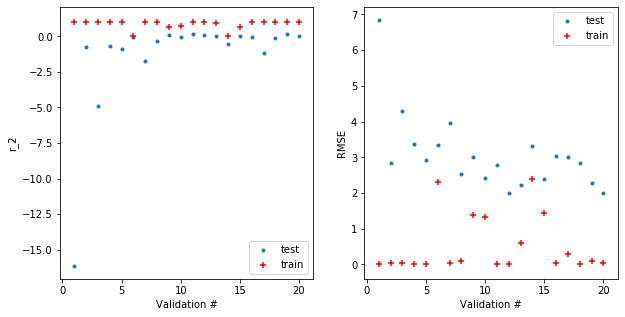

In [20]:
np.random.seed(0) # May change later

num_iter = 20

list_RMSE_training = []
list_RMSE_validation = []
list_r2_training = []
list_r2_validation = []
list_params = []
hyperparameter = 'lasso__alpha'

# search for smaller grid
param_grid = {'lasso__alpha': np.logspace(-3,1,10)}


for i in range(num_iter):
    df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_Y, test_size=0.20)
    df_X_train, df_y_train = shuffle(df_X_train, df_y_train)
    search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])
    yhat_train = search.best_estimator_.predict(df_X_train)
    train_score = search.best_estimator_.score(df_X_train, df_y_train.iloc[:,0])
    rmse_train = np.sqrt(mean_squared_error(df_y_train.iloc[:,0], yhat_train))
    yhat_valid = search.best_estimator_.predict(df_X_test)
    valid_score = search.best_estimator_.score(df_X_test, df_y_test.iloc[:,0])
    rmse_valid = np.sqrt(mean_squared_error(df_y_test.iloc[:,0], yhat_valid))

    list_RMSE_training.append(rmse_train)
    list_RMSE_validation.append(rmse_valid)
    list_r2_training.append(train_score)
    list_r2_validation.append(valid_score)
    list_params.append(search.best_params_[hyperparameter])

plot_sensitivity(list_r2_training, list_r2_validation, list_RMSE_training, list_RMSE_validation)

In [21]:
# print validation score with hyperparameters

print(list_params)

fmt = '%-5s%-25s%-20s'

print(fmt % ('', 'r2_valid', 'lasso_alpha'))
for i, (a, b) in enumerate(zip(list_r2_validation, list_params)):
    print(fmt % (i, a, b))

[0.001, 0.007742636826811269, 0.007742636826811269, 0.0027825594022071257, 0.0027825594022071257, 1.2915496650148828, 0.007742636826811269, 0.021544346900318832, 0.46415888336127775, 0.46415888336127775, 0.001, 0.001, 0.1668100537200059, 1.2915496650148828, 0.46415888336127775, 0.007742636826811269, 0.05994842503189409, 0.001, 0.021544346900318832, 0.007742636826811269]
     r2_valid                 lasso_alpha         
0    -16.173754982560624      0.001               
1    -0.7202291193146486      0.007742636826811269
2    -4.906487866024502       0.007742636826811269
3    -0.6414643101823319      0.0027825594022071257
4    -0.9168044492837567      0.0027825594022071257
5    -0.020497781377925017    1.2915496650148828  
6    -1.7442299431439277      0.007742636826811269
7    -0.2973881430731984      0.021544346900318832
8    0.07524580257845481      0.46415888336127775 
9    -0.02111532185578935     0.46415888336127775 
10   0.13917931613042056      0.001               
11   0.074344

LassoIC Training score: 0.0
Training RMSE: 2.7129861495345997
LassoIC Test score: -0.015053540698102717
Test RMSE: 2.0321512769393126


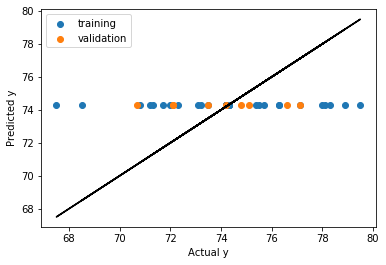

In [22]:
# from sklearn.linear_model import LassoLarsIC

# # Create pipeline
# scaler = StandardScaler()
# lasso = LassoLarsIC(criterion='bic', max_iter = 10000) 
# pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])

# # Fit 
# pipe.fit(df_X_train, df_y_train.iloc[:,0]) # Fit only the first column (dry 0 h)

# yhat_train = pipe.predict(df_X_train)
# print("LassoIC Training score: {}".format(pipe.score(df_X_train, df_y_train.iloc[:,0])))
# rmse_train = np.sqrt(mean_squared_error(df_y_train.iloc[:,0], yhat_train))
# print("Training RMSE: {}".format(rmse_train))
# yhat_test = pipe.predict(df_X_test)
# print("LassoIC Test score: {}".format(pipe.score(df_X_test, df_y_test.iloc[:,0])))
# rmse_test = np.sqrt(mean_squared_error(df_y_test.iloc[:,0], yhat_test))
# print("Test RMSE: {}".format(rmse_test))

# # Superimpose testing and training points
# fig, ax = plt.subplots()
# ax.scatter(df_y_train.iloc[:,0], yhat_train, label='training')
# ax.scatter(df_y_test.iloc[:,0], yhat_test, label='validation')
# ax.plot(df_y_train.iloc[:,0], df_y_train.iloc[:,0], 'k-')
# ax.set_xlabel("Actual y")
# ax.set_ylabel("Predicted y")
# ax.legend()

Best parameter (CV test score=3.557):
{'lasso__alpha': 0.005994842503189409}


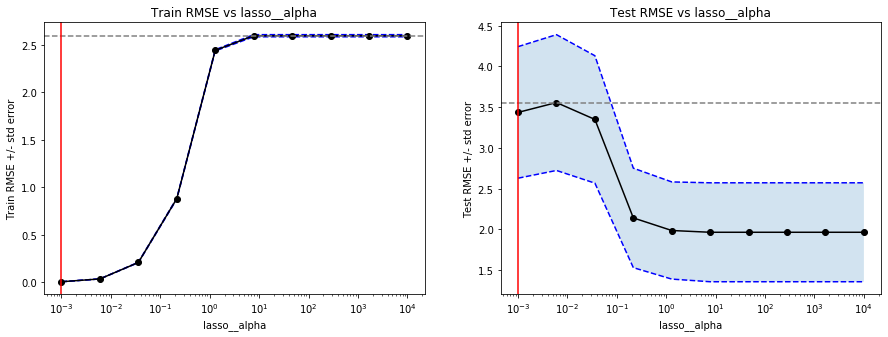

In [10]:
# case study for LASSO convergence

scaler = StandardScaler()
lasso = Lasso(max_iter = 5000, tol = 0.00001) 
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
param_grid = {'lasso__alpha': np.logspace(-3,4,10)}

search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

fig, ax = one_param_plotter(search, 'lasso__alpha', df_X_train, df_X_test, is_log=True)
ax[0].axvline(np.log(-0.5), 0, 1, color='r')
ax[0].axvline(0.001, 0, 1, color='r')
ax[1].axvline(np.log(-0.5), 0, 1, color='r')
ax[1].axvline(0.001, 0, 1, color='r')

In [25]:
a = search.best_estimator_.named_steps['lasso'].coef_

zeros = [_ for _ in a if np.isclose(_, 0)].__len__()
total = df_X_test.shape

print('total number of features used = {}'.format(total - zeros))

1842

## Improved Model 2 (Partial Least Squares Regression)

A PLS model may be more efficient than a PCR model because it extracts components using data in both X and Y. Since we have multiple response metrics in our data (6 different heat treatment columns), we may explore this as an option to extract information from our Y space in our final report. Additionally, it could be an appropriate choice when the dimensionality of the predictor space is larger than the number of observations. Here, we demonstrate it as a compact alternative to PCR:


$^1$ K. Dunn. *Process Improvement Using Data.*, 2018

In [25]:
from sklearn.cross_decomposition import PLSRegression

# Create pipeline
scaler = StandardScaler()
plsr = PLSRegression(max_iter = 100000, tol = 0.0001) 
pipe = Pipeline(steps=[('scaler', scaler), ('plsr', plsr)])
param_grid = {'plsr__n_components': 3+np.arange(17)}

search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

Best parameter (CV test score=2.769):
{'plsr__n_components': 10}


(<Figure size 1080x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a1df16e10>,
       dtype=object))

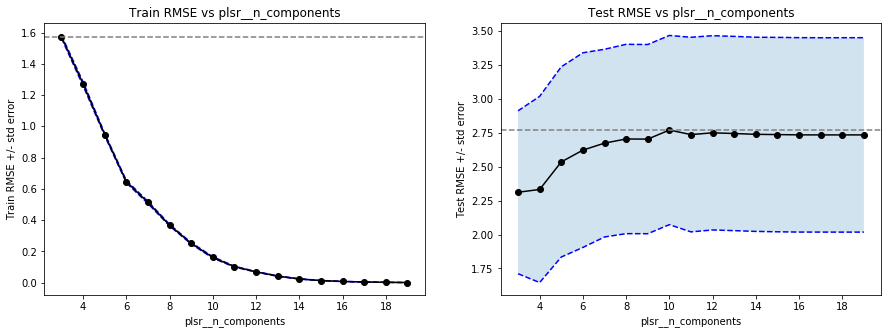

In [26]:
one_param_plotter(search, 'plsr__n_components', df_X_train, df_X_test, )

Best parameters: {'plsr__n_components': 10}
Training R2 score: 0.9960508898083076
Training RMSE: 0.17048932942350378
Validation R2 score: -0.1622021420986377
Validation RMSE: 2.17446486650032


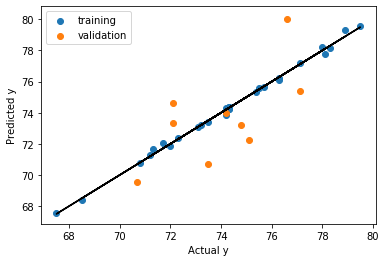

In [27]:
parity_plotter(search, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

Best parameter (CV test score=2.112):
{'plsr__n_components': 3}
Best parameter (CV test score=2.840):
{'plsr__n_components': 6}
Best parameter (CV test score=2.523):
{'plsr__n_components': 14}
Best parameter (CV test score=2.067):
{'plsr__n_components': 4}
Best parameter (CV test score=2.507):
{'plsr__n_components': 15}
Best parameter (CV test score=1.807):
{'plsr__n_components': 4}
Best parameter (CV test score=1.977):
{'plsr__n_components': 5}
Best parameter (CV test score=1.623):
{'plsr__n_components': 3}
Best parameter (CV test score=2.542):
{'plsr__n_components': 8}
Best parameter (CV test score=2.361):
{'plsr__n_components': 6}
Best parameter (CV test score=2.389):
{'plsr__n_components': 15}
Best parameter (CV test score=1.719):
{'plsr__n_components': 3}
Best parameter (CV test score=1.945):
{'plsr__n_components': 3}
Best parameter (CV test score=1.558):
{'plsr__n_components': 3}
Best parameter (CV test score=2.359):
{'plsr__n_components': 13}
Best parameter (CV test score=2.787)

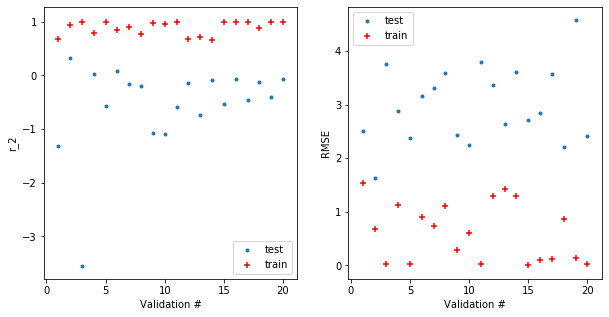

In [28]:
np.random.seed(0) # May change later

num_iter = 20

list_RMSE_training = []
list_RMSE_validation = []
list_r2_training = []
list_r2_validation = []
list_params = []
hyperparameter = 'plsr__n_components'

# search for smaller grid
# param_grid = {'lasso__alpha': np.logspace(-3,-0.5,10)}


for i in range(num_iter):
    df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_Y, test_size=0.20)
    df_X_train, df_y_train = shuffle(df_X_train, df_y_train)
    search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])
    yhat_train = search.best_estimator_.predict(df_X_train)
    train_score = search.best_estimator_.score(df_X_train, df_y_train.iloc[:,0])
    rmse_train = np.sqrt(mean_squared_error(df_y_train.iloc[:,0], yhat_train))
    yhat_valid = search.best_estimator_.predict(df_X_test)
    valid_score = search.best_estimator_.score(df_X_test, df_y_test.iloc[:,0])
    rmse_valid = np.sqrt(mean_squared_error(df_y_test.iloc[:,0], yhat_valid))

    list_RMSE_training.append(rmse_train)
    list_RMSE_validation.append(rmse_valid)
    list_r2_training.append(train_score)
    list_r2_validation.append(valid_score)
    list_params.append(search.best_params_[hyperparameter])

plot_sensitivity(list_r2_training, list_r2_validation, list_RMSE_training, list_RMSE_validation)


In [10]:

# Create pipeline
scaler = StandardScaler()
lr = LinearRegression()
krr = KernelRidge(kernel='rbf') 
pipe = Pipeline(steps=[('scaler', scaler), ('krr', krr)] )
param_grid = {'krr__gamma': np.logspace(-4,2,5),
              'krr__alpha': np.logspace(-8,5,5)}

search = gridsearch_pipeline_fit(pipe, param_grid, df_X_train, df_X_test, df_y_train.iloc[:,0], df_y_test.iloc[:,0])

Best parameter (CV test score=74.251):
{'krr__alpha': 100000.0, 'krr__gamma': 100.0}
